# Inspect Extracted Noise

We extract "noise" in the `seasonal-decomposition` step. 
Here we analyse it via a **scatter matrix** to inspect correlations with the features.

In [17]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

<AxesSubplot:>

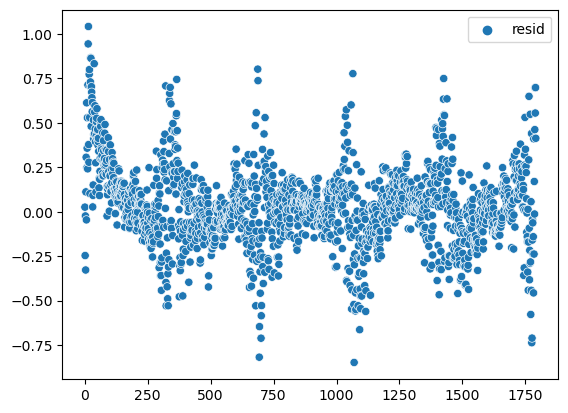

In [28]:
root = Path(r"..\data\villabate_fede")

df_noise = pd.read_pickle(root / "data\postprocessed" / "kc_noise.pickle").to_frame().reset_index()

sns.scatterplot(df_noise)

In [42]:
df_noise["DOY"] = df_noise.apply(lambda x: str(x.loc["Day"].day), axis=1)
df_noise

,Day,resid,DOY
0,2018-01-01,0.025968,1
1,2018-01-02,-0.246541,2
2,2018-01-03,-0.023615,3
3,2018-01-04,-0.327928,4
4,2018-01-05,0.111802,5
...,...,...,...
1788,2022-12-24,0.462199,24
1789,2022-12-25,0.698047,25
1790,2022-12-27,0.555606,27
1791,2022-12-28,0.698843,28


<AxesSubplot:xlabel='Day', ylabel='resid'>

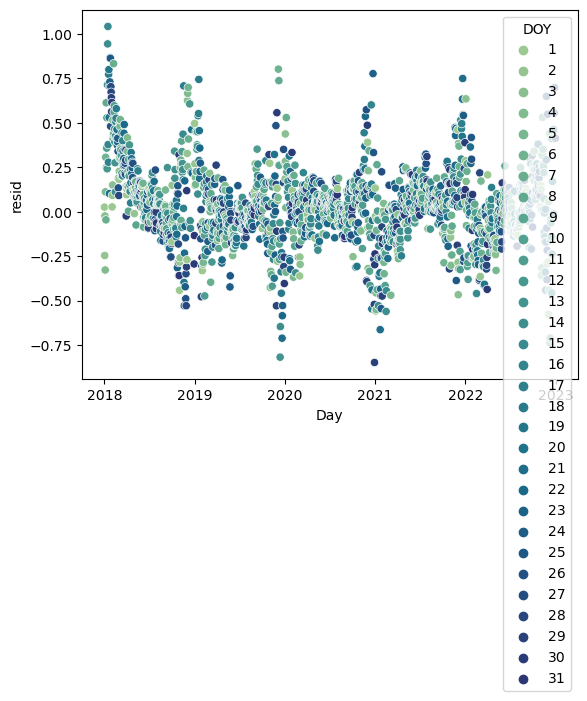

In [44]:
sns.scatterplot(df_noise, x="Day", y="resid", hue="DOY", palette="crest")